# Main plots - Figure 1 and Figures 3-6

# Zero-shot comparisons

Here we compare the zero-shot accuracies of various models to the fine-tuning performance of Llama-3.

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("colorblind")

from utils import load_responses, responses_to_acc, responses_to_counts
from utils import compute_averages, compute_mean_acc
from utils import majority_acc, majority_trials
from utils import clopper_pearson_ci, compute_bars, compute_case_acc, compute_task_bars

In [2]:
model_names = {
    'maj': 'Majority classifier',
    'legalbert': 'LegalBert',
    'mistral-7b-inst': 'Mistral 7B Inst',
    'saulinst': 'Saul 7B Inst',
    'mixtral-inst': 'Mixtral 8x7B Inst',
    'llama-3-8b-instruct': 'Llama 3 8B Inst',
    'llama-3-70b-instruct': 'Llama 3 70B Inst',
    'gpt4': 'GPT4',
    'lawma-8b': 'Lawma 8B',
    'lawma-70b': 'Lawma 70B',
}

models_to_load = list(set(model_names.keys()) - {'maj'})
base_dir = 'results/model_responses/'
responses = load_responses({}, models_to_load, base_dir)

100%|██████████| 260/260 [00:00<00:00, 288.75it/s]


llama-3-8b-instruct has 260 tasks


100%|██████████| 260/260 [00:00<00:00, 4962.50it/s]


gpt4 has 260 tasks


100%|██████████| 260/260 [00:00<00:00, 292.44it/s]


mistral-7b-inst has 260 tasks


100%|██████████| 260/260 [00:00<00:00, 311.35it/s]


lawma-8b has 260 tasks


100%|██████████| 260/260 [00:01<00:00, 227.65it/s]


lawma-70b has 260 tasks


100%|██████████| 260/260 [00:01<00:00, 252.79it/s]


mixtral-inst has 260 tasks


100%|██████████| 260/260 [00:00<00:00, 1467.58it/s]


legalbert has 260 tasks


100%|██████████| 260/260 [00:01<00:00, 189.00it/s]


saulinst has 260 tasks


100%|██████████| 260/260 [00:01<00:00, 249.21it/s]

llama-3-70b-instruct has 260 tasks


### Compute averages for all tasks

* `accs[model][task]` will contain the accuracy of model on task
* `trials[model][task]` will contain the number of successes and trials of model on each task

In [3]:
accs = {}
trials = {}
for model, model_responses in responses.items():
    accs[model] = {}
    trials[model] = {}
    for file, response in tqdm(model_responses.items()):
        a = responses_to_acc(response, gpt4=model=='gpt4')
        ts = responses_to_counts(response, gpt4=model=='gpt4')
        accs[model][file] = a
        trials[model][file] = ts

# compute accuracy of the majority classifier
accs['maj'] = {k: majority_acc(v) for k, v in list(responses.values())[0].items()}
trials['maj'] = {k: majority_trials(v) for k, v in list(responses.values())[0].items()}

# sc_issue and sc_casetyp1 are the average of certain tasks
tasks_to_average = {
    'sc_issue_': 'sc_issue',
    'songer_casetyp1_': 'songer_casetyp1',
}
averages = compute_averages(responses, tasks_to_average)
for model in accs.keys():
    for task in tasks_to_average.values():
        accs[model][task] = averages[model][task]

100%|██████████| 260/260 [00:00<00:00, 1120.02it/s]


# Zero shot plots

In [4]:
models_to_plot = [
    'maj',
    'legalbert',
    'mistral-7b-inst',
    'saulinst',
    'mixtral-inst',
    'llama-3-8b-instruct',
    'llama-3-70b-instruct',
    'gpt4',
]

prefixes = {
    '': 'All tasks',
    'sc_': 'Supreme Court tasks',
    'songer_': 'Court of Appeals tasks',
}

tasks = {
        'sc_issuearea': 'SC Issue Area',
        'sc_decisiondirection': 'SC Direction',
        'sc_casedisposition': 'SC Disposition',
        'sc_casesource': 'SC Case Source',
        'sc_lcdisposition': 'SC LC Disposition',
        'songer_geniss': 'Songer Gen. Issue',
        'songer_direct1': 'Songer Direction',
        'songer_treat': 'Songer Treatment',
        'songer_origin': 'Songer Case Origin',
        'sc_lcdispositiondirection': 'SC LC Direction',
}


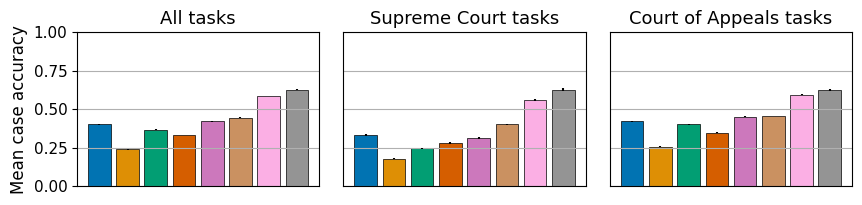

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(10, 2.), dpi=100, sharey=True, sharex=True)

for (prefix, title), ax in zip(prefixes.items(), axs):
    case_accuracy = {}
    bars = {}
    for model in models_to_plot:
        model_acc, model_bars = compute_case_acc(trials[model], prefix)
        case_accuracy[model] = model_acc
        bars[model] = model_bars
    
    y_axis = [case_accuracy[model] for model in models_to_plot]
    y_axis_bars = np.array([bars[model] for model in bars]).T    

    # each model should have a different color
    colors = [palette[i] for i in range(len(y_axis))]

    # plot
    ax.bar(range(len(y_axis)), y_axis, color=colors, edgecolor='black', linewidth=0.5, yerr=y_axis_bars)
    ax.set_xticks([])
    ax.set_title(title, fontsize=13)
    ax.yaxis.grid(True)
    ax.set_yticks(np.linspace(0, 1, 5))

for i in range(1, len(prefixes)):
    axs[i].yaxis.set_ticks_position('none')

axs[0].set_ylabel('Mean case accuracy', fontsize=12)
axs[0].set_ylim(0, 1)
axs[0].tick_params(axis='y', labelsize=11)
axs[0].set_yticks(np.linspace(0, 1, 5))
fig.subplots_adjust(wspace=0.1)
plt.savefig('plots/zero_shot_agg_case.pdf', bbox_inches='tight')

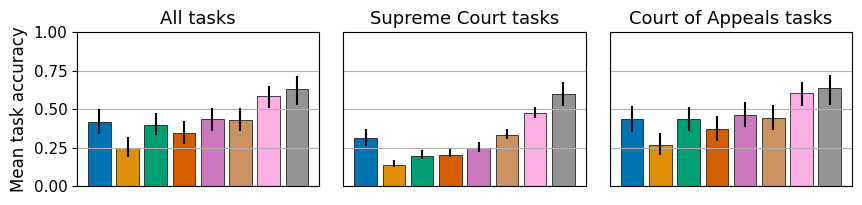

In [6]:
# Compute mean task accuracy plot
# This is taking the mean of task accuracies, i.e., a mean of means.
# This has high variance due to tasks with small number of cases

fig, axs = plt.subplots(1, 3, figsize=(10, 2.), dpi=100, sharey=True, sharex=True)

for (prefix, title), ax in zip(prefixes.items(), axs):
     # *average* error bars across tasks
    bars = {m: compute_task_bars(trials[m], prefix=prefix) for m in models_to_plot}
    y_axis = [compute_mean_acc(accs, model, prefix=prefix) for model in models_to_plot]

    # print(prefix)
    # print('-------')
    # for i, model in enumerate(models_to_plot):
    #     print(f'{model_names[model]}: {y_axis[i]*100:.1f}')

    y_axis_bars = np.array([bars[model] for model in bars]).T    

    # each model should have a different color
    colors = [palette[i] for i in range(len(y_axis))]

    # plot
    ax.bar(range(len(y_axis)), y_axis, color=colors, edgecolor='black', linewidth=0.5, yerr=y_axis_bars)
    ax.set_xticks([])
    ax.set_title(title, fontsize=13)
    ax.yaxis.grid(True)
    ax.set_yticks(np.linspace(0, 1, 5))

for i in range(1, len(prefixes)):
    axs[i].yaxis.set_ticks_position('none')

axs[0].set_ylabel('Mean task accuracy', fontsize=12)
axs[0].set_ylim(0, 1)
axs[0].tick_params(axis='y', labelsize=11)
axs[0].set_yticks(np.linspace(0, 1, 5))
fig.subplots_adjust(wspace=0.1)
plt.savefig('plots/zero_shot_agg_task.pdf', bbox_inches='tight')

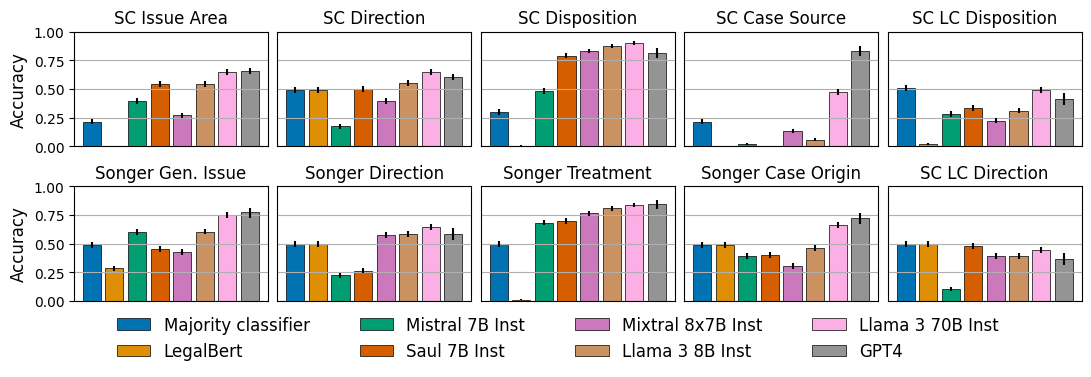

In [7]:
n_cols = len(tasks) // 2
fig, axs = plt.subplots(2, n_cols, figsize=(13, 3.5), dpi=100, sharex=True, sharey=True)

for task, task_name in tasks.items():
    # have a different color for each model
    i = list(tasks.keys()).index(task)
    ax = axs[i // n_cols, i % n_cols]
    
    y_axis = [accs[model][task] if model in accs and task in accs[model] else 0 for model in models_to_plot]
    y_axis_trials = [trials[model][task] if model in accs and task in accs[model] else 0 for model in models_to_plot]
    y_axis_cis = np.array([clopper_pearson_ci(s, n, 0.9) for (s, n) in y_axis_trials]).T
    y_axis_bars = np.abs(y_axis_cis - np.array([y_axis, y_axis]))
    
    c = [palette[i] for i in range(len(y_axis))]
    ax.bar(range(len(y_axis)), y_axis, color=c, edgecolor='black', linewidth=0.5, yerr=y_axis_bars)

    ax.set_title(task_name)
    ax.set_xticks([])
    ax.yaxis.grid(True)

    if i % n_cols != 0:
        ax.yaxis.set_ticks_position('none')
    else:
        ax.tick_params(axis='y', labelsize=10)
        ax.set_yticks(np.linspace(0, 1, n_cols))

# y axis label is accuracy
plt.ylim(0, 1)
plt.subplots_adjust(wspace=0.05, hspace=0.35)
axs[0, 0].set_ylabel('Accuracy', fontsize=12)
axs[-1, 0].set_ylabel('Accuracy', fontsize=12)

# manually create a legend with each model and its color
legend_elements = []
for model, c in zip(models_to_plot, palette):
    name = model_names[model]
    legend_elements.append(matplotlib.patches.Patch(facecolor=c, edgecolor='black', label=name, linewidth=0.5))
legend_position = (0.65, 0.)  # Coordinates (x, y) for top left position
axs[-1, -1].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=legend_position, frameon=False, ncols=len(models_to_plot)//2, fontsize=12, columnspacing=3.)#, handletextpad=-0.1, ncols=2, columnspacing=-0.7, fontsize=12)


# save as a pdf file
plt.savefig('plots/zero_shot_indiv.pdf', bbox_inches='tight')

# Lawma plots

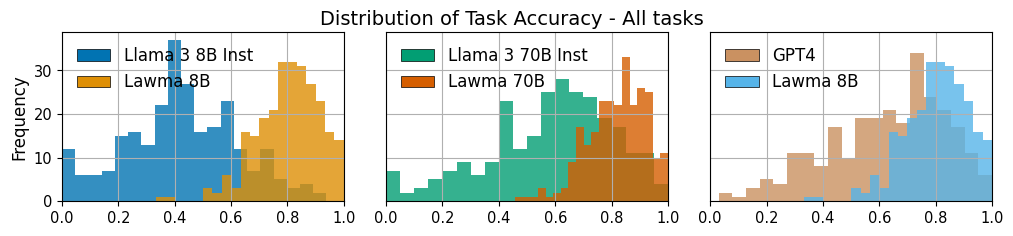

In [8]:
all_plot_models = [
    [
        'llama-3-8b-instruct',
        'lawma-8b',
    ],
     [
        'llama-3-70b-instruct',
        'lawma-70b',
     ],
     [
        'gpt4',
        'lawma-8b',
     ],
]

# 2 figures side by side
fig, axs = plt.subplots(1, 3, figsize=(12, 2.2), dpi=100, sharey=True, sharex=True)

palette_ids = [0, 1, 2, 3, 5, -1, 8]

for i, plot_models in enumerate(all_plot_models,):
    ax = axs[i]

    legend_elements = []
    # plot the histogram of accuracies of the model
    for j, plot_model in enumerate(plot_models):
        model_name = model_names[plot_model]
        accs_model = {k: v for k, v in accs[plot_model].items() if k.startswith('')}
        accs_model = list(accs_model.values())
        c = palette[palette_ids[i * 2 + j]]
        ax.hist(accs_model, bins=20, alpha=0.8, color=c)

        # add to legend
        legend_elements.append(matplotlib.patches.Patch(facecolor=c, edgecolor='black', label=model_name, linewidth=0.5))

    if i == 0:
        ax.set_ylabel('Frequency', fontsize=12)
    else:
        ax.yaxis.set_ticks_position('none')

    ax.set_xlim(0, 1)
    ax.grid()

    if i == 0:
        legend_position = (0.55, 0.85)  # Position to the right
        legend_alignment = 'left'
    else:
        legend_position = (0.0, 0.85)  # Position to the left
        legend_alignment = 'right'

    ax.legend(handles=legend_elements, loc='upper left', frameon=False,
              fontsize=12, ncol=1,  columnspacing=1., mode="expand")
    
# set super title
fig.suptitle('Distribution of Task Accuracy - All tasks', fontsize=14)
fig.subplots_adjust(wspace=0.15)

# set fontsize of ticks
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=10.5)

plt.savefig('plots/histogram.pdf', bbox_inches='tight')

Supreme Court: lawma-8b outperforms gpt4 in 0.9473684210526315 tasks
Court of Appeals: lawma-8b outperforms gpt4 in 0.9508928571428571 tasks
Supreme Court: lawma-8b outperforms gpt4 in 0.9473684210526315 tasks
Court of Appeals: lawma-8b outperforms gpt4 in 0.9508928571428571 tasks
Supreme Court: lawma-70b outperforms lawma-8b in 0.868421052631579 tasks
Court of Appeals: lawma-70b outperforms lawma-8b in 0.6383928571428571 tasks
Supreme Court: gpt4 outperforms maj in 0.868421052631579 tasks
Court of Appeals: gpt4 outperforms maj in 0.8303571428571429 tasks
Supreme Court: gpt4 outperforms llama-3-70b-instruct in 0.7368421052631579 tasks
Court of Appeals: gpt4 outperforms llama-3-70b-instruct in 0.6026785714285714 tasks


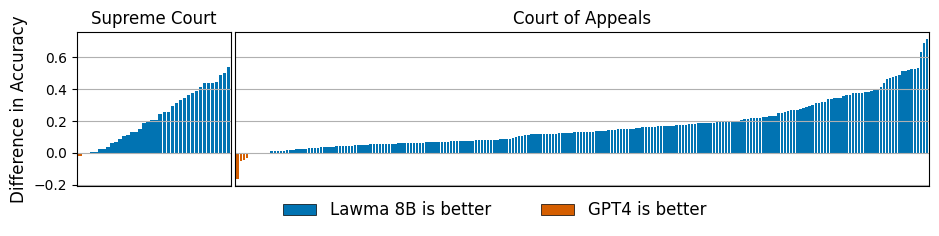

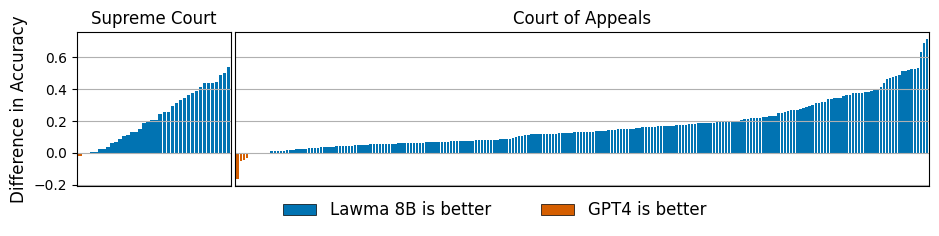

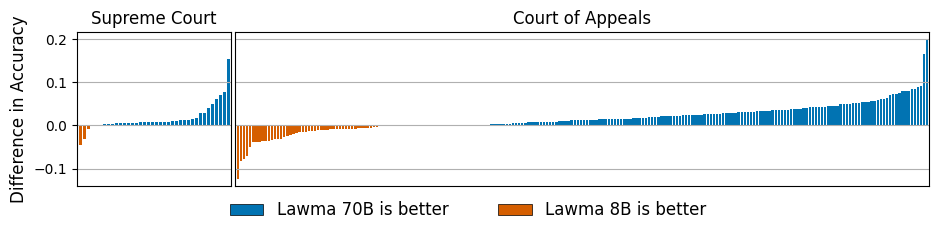

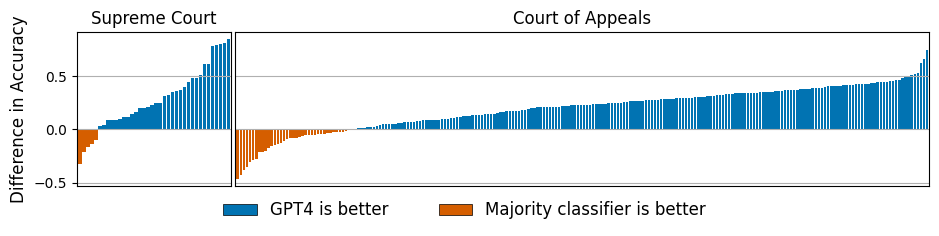

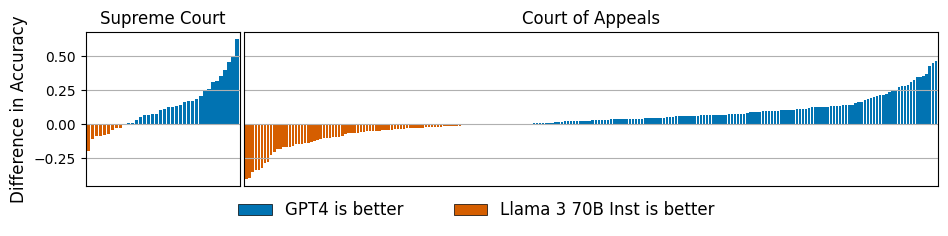

In [9]:
def compare_plot(plot_model, base_model):
    fig, axs = plt.subplots(1, 2, figsize=(11, 2.), gridspec_kw={'width_ratios': [1, 4.5]}, sharey=True)

    all_starts_with = {
        'sc_': 'Supreme Court',
        'songer_': 'Court of Appeals',
    }

    up_color = palette[0]
    down_color = palette[3]

    pos_neg = []
    for i, (starts_with, title) in enumerate(all_starts_with.items()):
        ax = axs[i]

        common_tasks = set(accs[plot_model].keys()) & set(accs[base_model].keys())
        common_tasks = [task for task in common_tasks if task.startswith(starts_with)]

        diff_acc = [accs[plot_model][task] - accs[base_model][task] for task in common_tasks]
        diff_acc = sorted(diff_acc)
        color = [up_color if acc > 0 else down_color for acc in diff_acc]

        pos_neg.extend([acc > 0 for acc in diff_acc])

        ax.bar(range(len(diff_acc)), diff_acc, color=color)
        ax.grid()
        ax.set_xticks([])
        ax.set_title(title, fontsize=12)
        ax.set_xlim(0-0.8, len(diff_acc)-0.3)

        if i == 0:
            ax.set_ylabel('Difference in Accuracy', fontsize=12)
        else:
            ax.yaxis.set_ticks_position('none')

        print(f'{title}: {plot_model} outperforms {base_model} in {np.mean([acc > 0 for acc in diff_acc])} tasks')


    # legend with "Llawma 8B is better" and "Llama 3 70B is better"
    legend_elements = [
        matplotlib.patches.Patch(facecolor=up_color, edgecolor='black', label=f'{model_names[plot_model]} is better', linewidth=0.5),
        matplotlib.patches.Patch(facecolor=down_color, edgecolor='black', label=f'{model_names[base_model]} is better', linewidth=0.5),
    ]
    legend_position = (0.7, -0.)  # Coordinates (x, y) for top left position
    axs[-1].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=legend_position, frameon=False, fontsize=12, columnspacing=3., ncols=2)

    # fig.suptitle('Difference in Accuracy - Lawma 8B vs Llama 3 70B Instruct - All Tasks', fontsize=12, y=1.1)
    fig.subplots_adjust(wspace=0.01)

compare_plot('lawma-8b', 'gpt4')
plt.savefig('plots/lawma8b_vs_gpt4.pdf', bbox_inches='tight')

compare_plot('lawma-8b', 'gpt4')
plt.savefig('plots/lawma70b_vs_gpt4.pdf', bbox_inches='tight')

compare_plot('lawma-70b', 'lawma-8b')
plt.savefig('plots/lawma70b_vs_lawma8b.pdf', bbox_inches='tight')

compare_plot('gpt4', 'maj')
plt.savefig('plots/gpt4_vs_maj.pdf', bbox_inches='tight')

compare_plot('gpt4', 'llama-3-70b-instruct')
plt.savefig('plots/gpt4_vs_llama70b.pdf', bbox_inches='tight')

In [10]:
models_to_plot = [
    'maj',
    'llama-3-8b-instruct',
    'llama-3-70b-instruct',
    'gpt4',
    'lawma-8b',
    'lawma-70b',
]

For , Lawma 8B outperforms 8B by 0.3769763282030391
For , Lawma 70B outperforms 70B by 0.23498540755210762
For , 70B outperforms 8B by 0.01588718039621484
For , Lawma 8B outperforms GPT4 by 0.1738546235341476
For , Lawma 70B outperforms GPT4 by 0.18974180393036244
For , 70B outperforms 8B by 0.01588718039621484

-------
Majority classifier: 41.7
Llama 3 8B Inst: 42.6
Llama 3 70B Inst: 58.4
GPT4: 62.9
Lawma 8B: 80.3
Lawma 70B: 81.9
For sc_, Lawma 8B outperforms 8B by 0.4962670245545451
For sc_, Lawma 70B outperforms 70B by 0.3696585311440987
For sc_, 70B outperforms 8B by 0.016676664990512235
For sc_, Lawma 8B outperforms GPT4 by 0.22645009217256096
For sc_, Lawma 70B outperforms GPT4 by 0.2431267571630732
For sc_, 70B outperforms 8B by 0.016676664990512235
sc_
-------
Majority classifier: 31.5
Llama 3 8B Inst: 32.8
Llama 3 70B Inst: 47.1
GPT4: 59.8
Lawma 8B: 82.4
Lawma 70B: 84.1
For songer_, Lawma 8B outperforms 8B by 0.3567395136434086
For songer_, Lawma 70B outperforms 70B by 0.21213

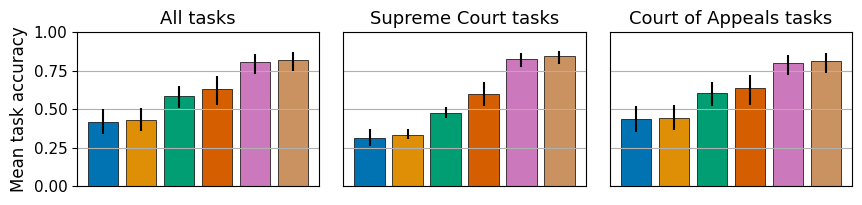

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(10, 2.), dpi=100, sharey=True, sharex=True)

for (prefix, title), ax in zip(prefixes.items(), axs):
    # compute *average* error bars across tasks
    bars = {m: compute_task_bars(trials[m], prefix=prefix) for m in models_to_plot}
    y_axis = [compute_mean_acc(accs, model, prefix=prefix) for model in models_to_plot]
    
    print(f"For {prefix}, Lawma 8B outperforms 8B by {y_axis[-2]-y_axis[-5]}")
    print(f"For {prefix}, Lawma 70B outperforms 70B by {y_axis[-1]-y_axis[-4]}")
    print(f"For {prefix}, 70B outperforms 8B by {y_axis[-1]-y_axis[-2]}")
    print(f"For {prefix}, Lawma 8B outperforms GPT4 by {y_axis[-2]-y_axis[-3]}")
    print(f"For {prefix}, Lawma 70B outperforms GPT4 by {y_axis[-1]-y_axis[-3]}")
    print(f"For {prefix}, 70B outperforms 8B by {y_axis[-1]-y_axis[-2]}")
    y_axis_bars = np.array([bars[model] for model in bars]).T

    print(prefix)
    print('-------')
    for i, model in enumerate(models_to_plot):
        print(f'{model_names[model]}: {y_axis[i]*100:.1f}')
 
    # each model should have a different color
    colors = [palette[i] for i in range(len(y_axis))]

    # plot
    ax.bar(range(len(y_axis)), y_axis, color=colors, edgecolor='black', linewidth=0.5, yerr=y_axis_bars)
    ax.set_xticks([])
    ax.set_title(title, fontsize=13)
    ax.yaxis.grid(True)
    ax.set_yticks(np.linspace(0, 1, 5))

for i in range(1, len(prefixes)):
    axs[i].yaxis.set_ticks_position('none')

axs[0].set_ylabel('Mean task accuracy', fontsize=12)
axs[0].set_ylim(0, 1)
axs[0].tick_params(axis='y', labelsize=11)
axs[0].set_yticks(np.linspace(0, 1, 5))
fig.subplots_adjust(wspace=0.1)
plt.savefig('plots/ft_agg_task.pdf', bbox_inches='tight')

For , 70B outperforms 8B by 0.014051144010767236
For sc_, 70B outperforms 8B by 0.009322498629044329
For songer_, 70B outperforms 8B by 0.015353768402548873


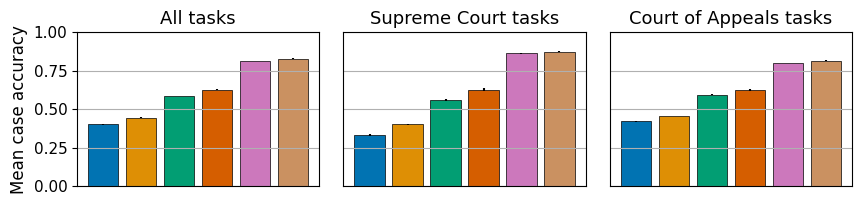

In [12]:
## Compute mean case accuracy plot
# This is averaging over all cases

prefixes = {
    '': 'All tasks',
    'sc_': 'Supreme Court tasks',
    'songer_': 'Court of Appeals tasks',
}
fig, axs = plt.subplots(1, 3, figsize=(10, 2.), dpi=100, sharey=True, sharex=True)


for (prefix, title), ax in zip(prefixes.items(), axs):
    case_accuracy = {}
    bars = {}
    for model in models_to_plot:
        model_acc, model_bars = compute_case_acc(trials[model], prefix)
        case_accuracy[model] = model_acc
        bars[model] = model_bars
    
    y_axis = [case_accuracy[model] for model in models_to_plot]
    print(f"For {prefix}, 70B outperforms 8B by {y_axis[-1]-y_axis[-2]}")
    y_axis_bars = np.array([bars[model] for model in bars]).T
 
    # each model should have a different color
    colors = [palette[i] for i in range(len(y_axis))]

    # plot
    ax.bar(range(len(y_axis)), y_axis, color=colors, edgecolor='black', linewidth=0.5, yerr=y_axis_bars)
    ax.set_xticks([])
    ax.set_title(title, fontsize=13)
    ax.yaxis.grid(True)
    ax.set_yticks(np.linspace(0, 1, 5))

for i in range(1, len(prefixes)):
    axs[i].yaxis.set_ticks_position('none')

axs[0].set_ylabel('Mean case accuracy', fontsize=12)
axs[0].set_ylim(0, 1)
axs[0].tick_params(axis='y', labelsize=11)
axs[0].set_yticks(np.linspace(0, 1, 5))
# tight layout
# plt.tight_layout()
fig.subplots_adjust(wspace=0.1)
plt.savefig('plots/ft_agg_case.pdf', bbox_inches='tight')

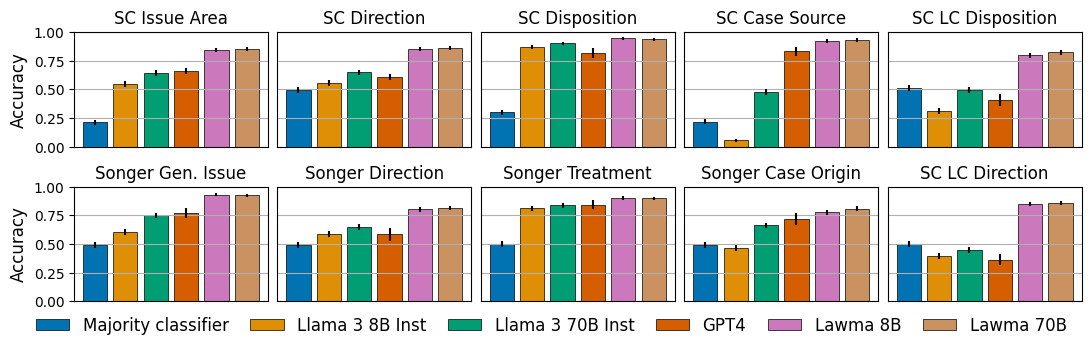

In [13]:
n_cols = len(tasks) // 2
fig, axs = plt.subplots(2, n_cols, figsize=(13, 3.5), dpi=100, sharex=True, sharey=True)

for task, task_name in tasks.items():
    # have a different color for each model
    i = list(tasks.keys()).index(task)
    ax = axs[i // n_cols, i % n_cols]
    
    y_axis = [accs[model][task] if model in accs and task in accs[model] else 0 for model in models_to_plot]
    y_axis_trials = [trials[model][task] if model in accs and task in accs[model] else 0 for model in models_to_plot]
    y_axis_cis = np.array([clopper_pearson_ci(s, n, 0.9) for (s, n) in y_axis_trials]).T
    y_axis_bars = np.abs(y_axis_cis - np.array([y_axis, y_axis]))
    c = [palette[i] for i in range(len(y_axis))]

    ax.bar(range(len(y_axis)), y_axis, color=c, edgecolor='black', linewidth=0.5, yerr=y_axis_bars)

    ax.set_title(task_name)
    ax.set_xticks([])
    ax.yaxis.grid(True)

    if i % n_cols != 0:
        ax.yaxis.set_ticks_position('none')
    else:
        ax.tick_params(axis='y', labelsize=10)
        ax.set_yticks(np.linspace(0, 1, n_cols))

# y axis label is accuracy
plt.ylim(0, 1)
plt.subplots_adjust(wspace=0.05, hspace=0.35)
axs[0, 0].set_ylabel('Accuracy', fontsize=12)
axs[-1, 0].set_ylabel('Accuracy', fontsize=12)

# manually create a legend with each model and its color
legend_elements = []
for model, c in zip(models_to_plot, palette):
    name = model_names[model]
    legend_elements.append(matplotlib.patches.Patch(facecolor=c, edgecolor='black', label=name, linewidth=0.5))
legend_position = (1, 0.)  # Coordinates (x, y) for top left position
axs[-1, -1].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=legend_position, frameon=False, ncols=len(models_to_plot), fontsize=12, columnspacing=1.3)#, handletextpad=-0.1, ncols=2, columnspacing=-0.7, fontsize=12)


# save as a pdf file
plt.savefig('plots/ft_indiv.pdf', bbox_inches='tight')